In [47]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from itertools import chain
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.plots import display_candidate_loss
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.torch_fwrf import get_value

In [3]:
from imp import reload
import src.torch_fwrf as aaa
reload(aaa)
from src.torch_fwrf import linspace, logspace, model_space, learn_params_ridge_regression, get_predictions

In [4]:
import torch
import torch.nn as nn

print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [5]:
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'deepnet-fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
output_dir = root_dir+"output/S%02d/" % (subject) 
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

Time Stamp: Apr-10-2020_2223


# Load stimuli

In [6]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [7]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli']).astype(np.float32) / 255.
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

(10000, 3, 227, 227)
float32
0.0 1.0


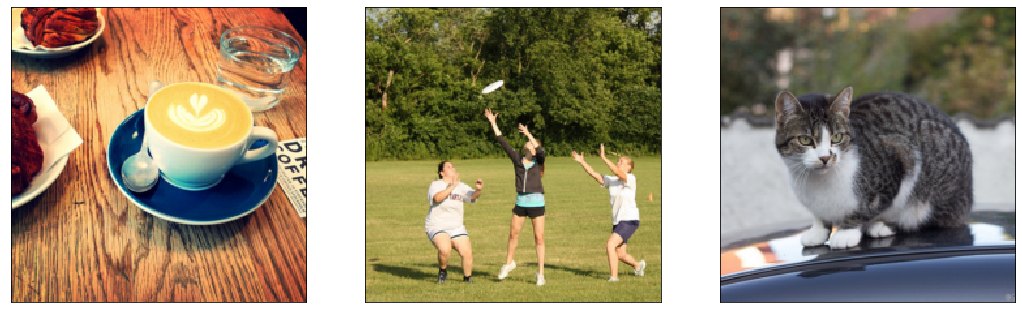

In [8]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load Voxels

In [9]:
from src.file_utility import load_mask_from_nii, view_data

In [10]:
voxel_r2_full      = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%(subject))
tight_mask_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%subject)
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
voxel_roi_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))

brain_nii_shape = brain_mask_full.shape

brain_mask_full = tight_mask_full.flatten().astype(bool)
voxel_r2_brain  = voxel_r2_full.flatten()[brain_mask_full]
voxel_idx_brain = np.arange(len(brain_mask_full))[brain_mask_full]
voxel_roi_brain = voxel_roi_full.flatten()[brain_mask_full]

general_mask_full = (general_mask_full==1).flatten().astype(bool)
voxel_r2_general  = voxel_r2_full.flatten()[general_mask_full]
voxel_idx_general = np.arange(len(general_mask_full))[general_mask_full]
voxel_roi_general = voxel_roi_full.flatten()[general_mask_full]

## Display a slice of the data

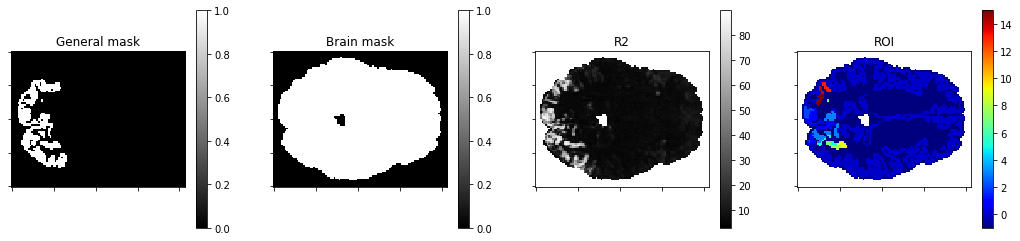

In [11]:
volume_r2         = view_data(voxel_r2_full.shape, voxel_idx_brain, np.nan_to_num(voxel_r2_brain))
volume_general_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), general_mask_full)
volume_brain_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), brain_mask_full)
volume_brain_roi  = view_data(voxel_r2_full.shape, voxel_idx_brain, voxel_roi_brain)

slice_idx = 40
fig = plt.figure(figsize=(18,4))
plt.subplot(1,4,1)
plt.imshow(volume_general_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('General mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,2)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Brain mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,3)
plt.imshow(volume_r2[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('R2')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,4)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

## Select what mask to use

In [12]:
voxel_mask = general_mask_full
voxel_idx = voxel_idx_general
voxel_roi = voxel_roi_general
voxel_r2  = voxel_r2_general

In [13]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=-1)
print (voxel_data.shape)

/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.066, <sigma> = 0.915
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.927, <sigma> = 0.826
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.163, <sigma> = 0.944
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.886, <sigma> = 0.797
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.007, <sigma> = 0.892
/home/styvesg/repo.data/datasets/ns

## Voxel grouping and voxel ROI iterator

In [14]:
from src.roi import iterate_roi, roi_map

roi_group_names = ['V1', 'V2', 'V3', 'V4', 'VO', 'PHC', 'MST', 'hMT', 'LO', 'V3a/b', 'IPS', 'All']
roi_group = [[1,2],[3,4],[5,6], [7], [8,9], [10,11], [12], [13], [14,15], [16,17], [18,19,20,21,22,23], np.arange(0,24)]
for roi_mask, roi_name in iterate_roi(roi_group, voxel_roi, roi_map, group_name=roi_group_names):
    print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

1982 	: V1
1565 	: V2
1385 	: V3
462 	: V4
519 	: VO
374 	: PHC
54 	: MST
281 	: hMT
517 	: LO
875 	: V3a/b
931 	: IPS
15608 	: All


## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [15]:
data_size, nv = voxel_data.shape 
print ("Total number of voxels = %d" % nv)

ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices

val_size = np.sum(shared_mask)
trn_size = data_size - val_size
print ("Validation size =", val_size, ", Training size =", trn_size)

Total number of voxels = 15660
Validation size = 3000 , Training size = 27000


In [16]:
## double and triple check that I haven't misaligned the image and responses.
trn_voxel_data = voxel_data[~shared_mask]
val_voxel_data = voxel_data[shared_mask]

stim_data = image_data[ordering_data]  # reduce to only the samples available thus far

trn_stim_data = stim_data[~shared_mask]
val_stim_data = stim_data[shared_mask]

In [17]:
del stim_data
del voxel_data

# Create model
By arbitrary convention, all variables, ojects or functions that return either of those on the device will begin with an underscore.

In [18]:
from torchvision.models.alexnet import Alexnet_fmaps
_fmaps_fn = Alexnet_fmaps().to(device)

_x = torch.tensor(image_data[:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 64, 27, 27])
torch.Size([100, 192, 27, 27])
torch.Size([100, 384, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 1000, 1, 1])


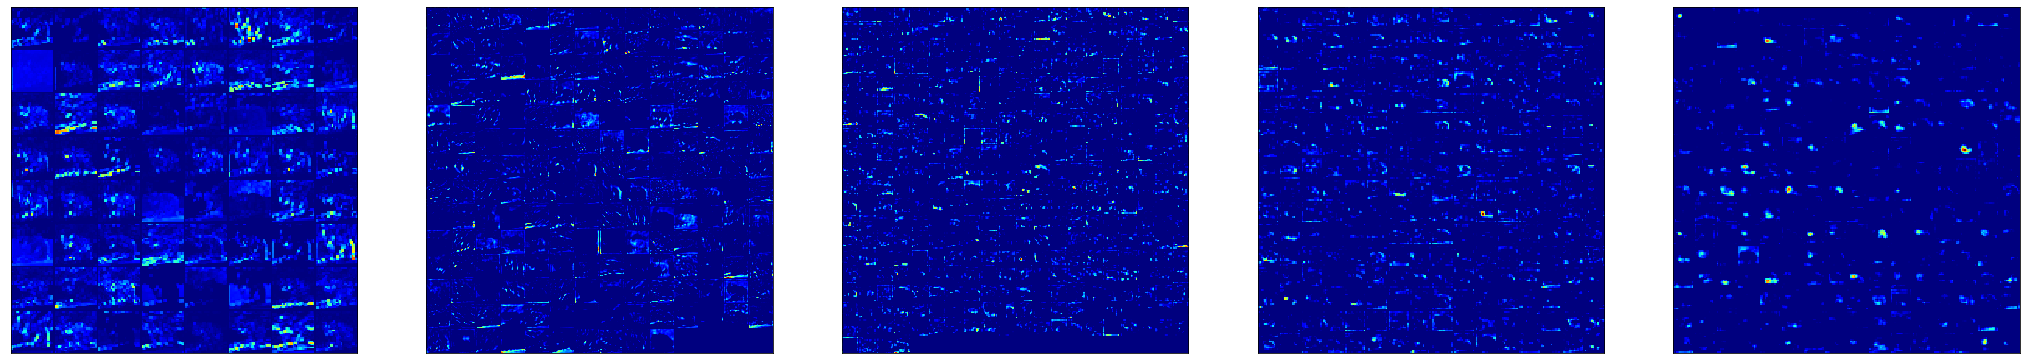

In [19]:
plt.figure(figsize=(36,12))
for k,_fm in enumerate(_fmaps[:5]):
    plt.subplot(1,5,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[8], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

# Filter down the feature map extractor

In [20]:
from src.torch_feature_space import filter_dnn_feature_maps

# I used image_data because the repeats are not relevant
_fmaps_fn, lmask, fmask, tuning_masks = filter_dnn_feature_maps(image_data, _fmaps_fn, batch_size=100, fmap_max=512, concatenate=False)

100it [00:08, 11.92it/s]

layer: 0, shape=(100, 64, 27, 27)
layer: 1, shape=(100, 192, 27, 27)
layer: 2, shape=(100, 384, 13, 13)
layer: 3, shape=(100, 256, 13, 13)
layer: 4, shape=(100, 256, 13, 13)
layer: 5, shape=(100, 512, 1, 1)
layer: 6, shape=(100, 512, 1, 1)
layer: 7, shape=(100, 512, 1, 1)



In [21]:
_x = torch.tensor(image_data[:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 64, 27, 27])
torch.Size([100, 192, 27, 27])
torch.Size([100, 384, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 512, 1, 1])
torch.Size([100, 512, 1, 1])
torch.Size([100, 512, 1, 1])


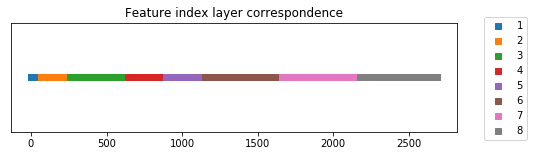

In [22]:
plt.figure(figsize=(8, 2))
for k,tm in enumerate(tuning_masks):
    _=plt.plot(tm, marker='s', linestyle='None', label=k+1)
_=plt.title('Feature index layer correspondence')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.1))

# fwRF training procedure
The model is
$$ r(t) = b + W * [f(\int_\mathrm{space}\phi(x,y,t) * g(x,y) dxdy) - m] / \sigma $$
where
$g(x,y)$ is a gaussian pooling field shared by all feature maps

$\phi(x,y,t)$ are the feature maps corresponding to stimuli $t$

$W, b$ are the feature weights and bias of the linearized model for each voxels

$f(\cdot)$ is an optional nonlinearity

$m,\sigma$ are normalization coefficient to facilitate regularization

In [1]:
from src.torch_pfwrf import learn_params_gradient, get_predictions, Torch_fwRF_voxel_block

In [24]:
sample_batch_size = 200
voxel_batch_size = 500
holdout_size = 6000

_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, _nonlinearity=None, \
                 input_space=227, max_fpf_resolution=27, voxel_batch_size=voxel_batch_size , shared_fpf=False)
print ('')    
param_count = 0
for _p in _fwrf_fn.parameters():
    print (_p.size())
    param_count += np.prod(_p.size())
print (param_count // voxel_batch_size, "approx fwrf params per voxels")

native fpf resolution 27
native fpf resolution 27
native fpf resolution 13
native fpf resolution 13
native fpf resolution 13
native fpf resolution 1
native fpf resolution 1
native fpf resolution 1

torch.Size([500, 27, 27])
torch.Size([500, 27, 27])
torch.Size([500, 13, 13])
torch.Size([500, 13, 13])
torch.Size([500, 13, 13])
torch.Size([500, 1, 1])
torch.Size([500, 1, 1])
torch.Size([500, 1, 1])
torch.Size([500, 2688])
torch.Size([500])
4657 approx fwrf params per voxels


In [26]:
best_losses, best_epochs, best_params = \
    learn_params_gradient(trn_stim_data, trn_voxel_data, _fmaps_fn, _fwrf_fn, \
        sample_batch_size=200, holdout_size=holdout_size, num_epochs = 25, lr=2e-5, l1=1e-2, l2=0.)

trn_size = 21000 (77.8%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
voxels [ 15500:15659 ] of 15660, epoch  25 of  25, loss = 0.266190 (24))

In [27]:
val_voxel_pred = get_predictions(val_stim_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=200)

val_size = 3000
---------------------------------------
total time = 35.211652s
sample throughput = 0.011737s/sample
voxel throughput = 0.002249s/voxel


In [28]:
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

100%|██████████| 15660/15660 [00:02<00:00, 7555.51it/s]


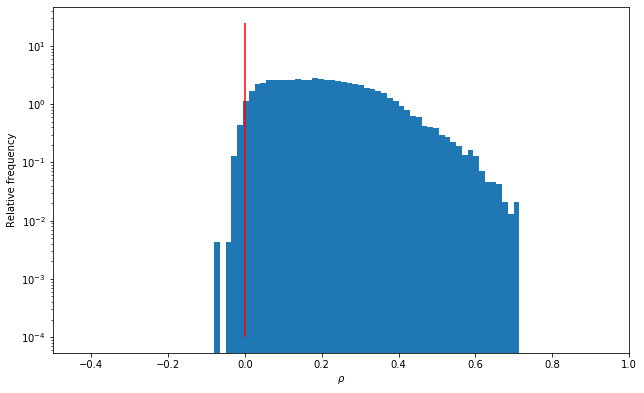

In [29]:
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.5, 1.0])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

Text(0, 0.5, 'Count')

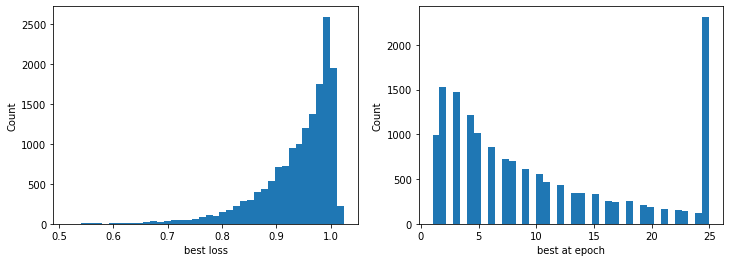

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
_=plt.hist(best_losses, bins=40)
plt.xlabel('best loss')
plt.ylabel('Count')
plt.subplot(1,2,2)
_=plt.hist(best_epochs, bins=40)
plt.xlabel('best at epoch')
plt.ylabel('Count')

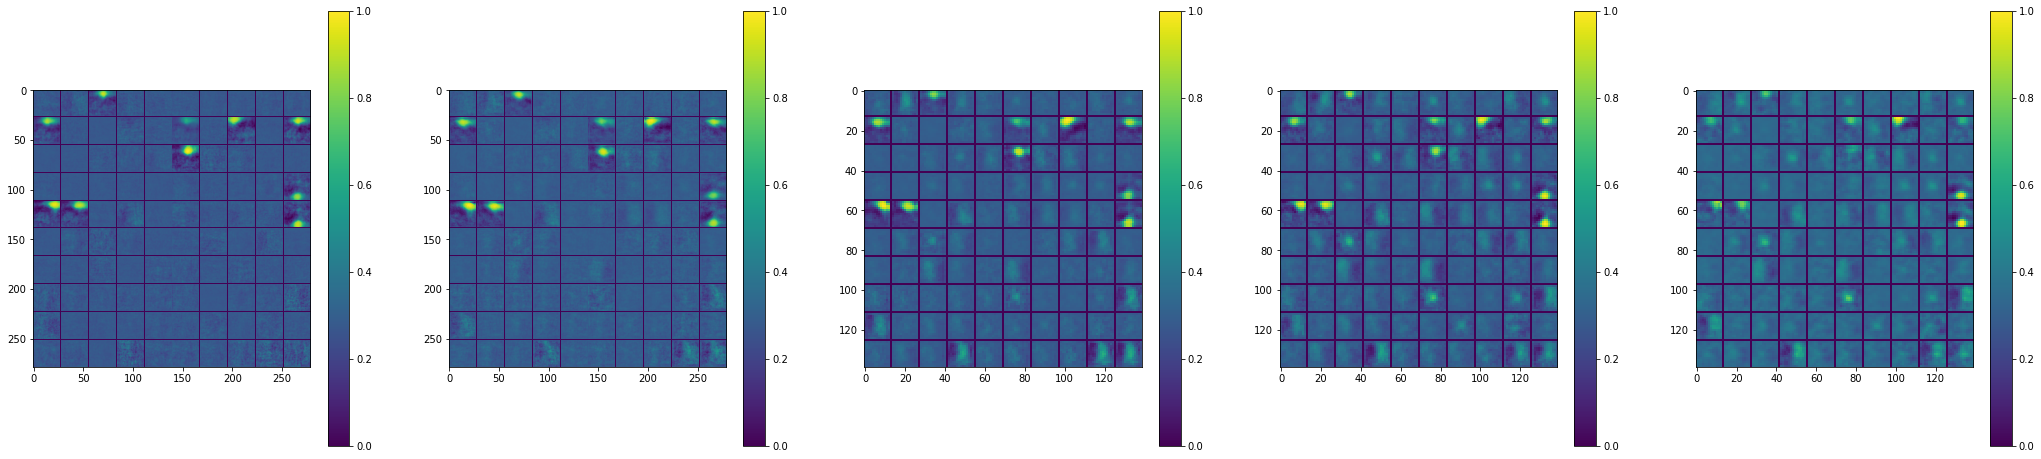

In [45]:
show_fpf = 5

def pooling_fn(x):
    return np.exp(x) / np.sum(np.exp(x), axis=(1,2), keepdims=True)
plt.figure(figsize=(36,8))
for l in range(show_fpf):
    plt.subplot(1, show_fpf, l+1)
    plt.imshow(pnu.mosaic_vis(pooling_fn(best_params[l][np.argsort(val_cc)[-100:]]), pad=1))
    plt.colorbar()

# Compare validation accuracy value to previous method

In [31]:
pre_cc_volume  = load_mask_from_nii(output_dir + "val_cc_Mar-27-2020_0301.nii")
pre_cc = pre_cc_volume.flatten()[general_mask_full]

<Figure size 576x576 with 0 Axes>

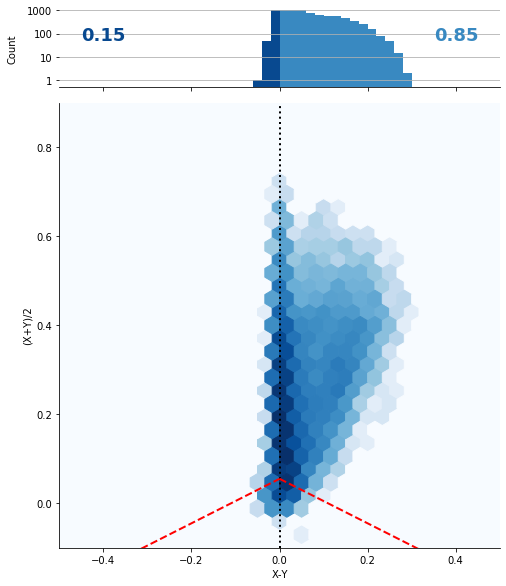

In [32]:
from src.plots import plot_fwrf_paper_compare

fig=plt.figure(figsize=(8, 8))
_=plot_fwrf_paper_compare(pre_cc, val_cc, 0.055, [-.5, .5], [-.1, .9])

# Save results

In [33]:
model_params = {
    'lmask': lmask,
    'fmask': fmask,
    'tuning_masks': tuning_masks,
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'val_size': val_size,
    'trn_size': trn_size,
    'shared_mask': shared_mask,
    'image_order': ordering_data,
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi,
    'best_losses': best_losses,
    'best_epochs': best_epochs, 
    'params': best_params,
    'val_cc': val_cc,
    }

param_file_name = "pfwrf_%s_params" % (timestamp)
print (param_file_name)

save_stuff(output_dir + param_file_name, flatten_dict(model_params))

pfwrf_Apr-10-2020_2223_params
saved lmask@0 in h5py file
saved lmask@1 in h5py file
saved lmask@2 in h5py file
saved lmask@3 in h5py file
saved lmask@4 in h5py file
saved lmask@5 in h5py file
saved lmask@6 in h5py file
saved lmask@7 in h5py file
saved fmask@0 in h5py file
saved fmask@1 in h5py file
saved fmask@2 in h5py file
saved fmask@3 in h5py file
saved fmask@4 in h5py file
saved fmask@5 in h5py file
saved fmask@6 in h5py file
saved fmask@7 in h5py file
saved tuning_masks@0 in h5py file
saved tuning_masks@1 in h5py file
saved tuning_masks@2 in h5py file
saved tuning_masks@3 in h5py file
saved tuning_masks@4 in h5py file
saved tuning_masks@5 in h5py file
saved tuning_masks@6 in h5py file
saved tuning_masks@7 in h5py file
saved voxel_mask in h5py file
saved brain_nii_shape in h5py file
saved val_size in h5py file
saved trn_size in h5py file
saved shared_mask in h5py file
saved image_order in h5py file
saved voxel_index in h5py file
saved voxel_roi in h5py file
saved best_losses in h5

# Training sample scaling

In [34]:
trn_sizes = np.array([1,2,3,6,9,18,27]) * 1000
holdout_perc = .2
ho_sizes = np.floor(holdout_perc * trn_sizes).astype(int)
print (trn_sizes)

[ 1000  2000  3000  6000  9000 18000 27000]


In [35]:
characteristics = {'trn_sizes': trn_sizes,
                  'ho_sizes': ho_sizes,
                  'voxel_index': voxel_idx,
                  'voxel_roi': voxel_roi}
###
for k,(ts,hs) in enumerate(zip(trn_sizes, ho_sizes)):  
    # training    
    best_losses, best_epochs, best_params = \
        learn_params_gradient(trn_stim_data[:ts], trn_voxel_data[:ts], _fmaps_fn, _fwrf_fn, \
            sample_batch_size=sample_batch_size, holdout_size=hs, num_epochs = 25, lr=5e-5, l1=1e-2, l2=0.)
    # validation
    val_voxel_pred = get_predictions(val_stim_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=200)    
    # prediction accuracy
    val_cc = np.zeros(shape=(nv,), dtype=fpX)    
    for v in tqdm(range(nv)):    
        val_cc[v] = np.corrcoef(val_voxel_pred[:,v], val_voxel_data[:,v])[0,1]
    # null threshold  
    null_val_cc = np.zeros(shape=(10, nv), dtype=fpX)
    for i in range(10):
        shuff = np.arange(len(val_voxel_pred))
        np.random.shuffle(shuff)
        shuffled_val_pred = val_voxel_pred[shuff]
        for v in tqdm(range(nv)):    
            null_val_cc[i,v] = np.corrcoef(shuffled_val_pred[:,v], val_voxel_data[:,v])[0,1]
    cc_mn = np.mean(null_val_cc.flatten())
    cc_th = 3* np.std(null_val_cc.flatten())
    # save results 
    characteristics['result%d'%k] = {'trn_size': ts,
                          'cc_mn':        cc_mn,
                          'cc_th':        cc_th,
                          'val_cc':       val_cc}
    # print a summary
    print ('================================================')
    print ('median cc = %.3f, max cc = %.3f' % (np.median(val_cc), np.max(val_cc)))
    print ('================================================')
#################################################################    
characteristics['max_trn_size'] = trn_size
characteristics['val_size'] = val_size
## cc_threshold patch
cc_mns, cc_ths = [],[]
for i,ts in enumerate(characteristics['trn_sizes']):
    cc_mns += [characteristics['result%d'%i]['cc_mn'],]
    cc_ths += [characteristics['result%d'%i]['cc_th'],]  
cc_mn = np.mean(cc_mns)    
cc_th = np.mean(cc_ths)
print ("cc th = (%.3f, %.3f)" % (cc_mn, cc_th))
characteristics['cc_mn'] = cc_mn
characteristics['cc_th'] = cc_th

trn_size = 800 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
voxels [ 15500:15659 ] of 15660, epoch  25 of  25, loss = 0.271730 (29)val_size = 3000


  5%|▍         | 716/15660 [00:00<00:02, 7152.61it/s]

---------------------------------------
total time = 35.198334s
sample throughput = 0.011733s/sample
voxel throughput = 0.002248s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7511.92it/s]


median cc = 0.122, max cc = 0.679
trn_size = 1600 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
voxels [ 15500:15659 ] of 15660, epoch  25 of  25, loss = 0.263494 (19)val_size = 3000


  4%|▍         | 676/15660 [00:00<00:02, 6758.31it/s]

---------------------------------------
total time = 35.160324s
sample throughput = 0.011720s/sample
voxel throughput = 0.002245s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7495.04it/s]


median cc = 0.148, max cc = 0.688
trn_size = 2400 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
voxels [ 15500:15659 ] of 15660, epoch  25 of  25, loss = 0.270678 (4)val_size = 3000


  5%|▍         | 742/15660 [00:00<00:02, 7414.70it/s]

---------------------------------------
total time = 35.145504s
sample throughput = 0.011715s/sample
voxel throughput = 0.002244s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7285.96it/s]


median cc = 0.161, max cc = 0.694
trn_size = 4800 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
voxels [ 15500:15659 ] of 15660, epoch  25 of  25, loss = 0.269991 (0)val_size = 3000


  5%|▍         | 742/15660 [00:00<00:02, 7416.06it/s]

---------------------------------------
total time = 35.210559s
sample throughput = 0.011737s/sample
voxel throughput = 0.002248s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7488.62it/s]


median cc = 0.177, max cc = 0.700
trn_size = 7200 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
voxels [ 15500:15659 ] of 15660, epoch  25 of  25, loss = 0.271690 (0)val_size = 3000


  5%|▍         | 743/15660 [00:00<00:02, 7422.01it/s]

---------------------------------------
total time = 35.217495s
sample throughput = 0.011739s/sample
voxel throughput = 0.002249s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7358.35it/s]


median cc = 0.182, max cc = 0.706
trn_size = 14400 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
voxels [ 15500:15659 ] of 15660, epoch  25 of  25, loss = 0.272325 (0)val_size = 3000


  5%|▍         | 746/15660 [00:00<00:02, 7451.34it/s]

---------------------------------------
total time = 35.261147s
sample throughput = 0.011754s/sample
voxel throughput = 0.002252s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7467.78it/s]


median cc = 0.192, max cc = 0.710
trn_size = 21600 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
voxels [ 15500:15659 ] of 15660, epoch  25 of  25, loss = 0.269871 (0)val_size = 3000


  5%|▍         | 750/15660 [00:00<00:01, 7497.59it/s]

---------------------------------------
total time = 35.242503s
sample throughput = 0.011748s/sample
voxel throughput = 0.002250s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7532.69it/s]

median cc = 0.195, max cc = 0.713
cc th = (-0.001, 0.055)


## Save scaling data

In [36]:
param_file_name = "dnn_pfwrf_%s_scaling" % (timestamp)
print (param_file_name)

save_stuff(output_dir + param_file_name, flatten_dict(characteristics))

dnn_pfwrf_Apr-10-2020_2223_scaling
saved trn_sizes in h5py file
saved ho_sizes in h5py file
saved voxel_index in h5py file
saved voxel_roi in h5py file
saved result0.trn_size in h5py file
saved result0.cc_mn in h5py file
saved result0.cc_th in h5py file
saved result0.val_cc in h5py file
saved result1.trn_size in h5py file
saved result1.cc_mn in h5py file
saved result1.cc_th in h5py file
saved result1.val_cc in h5py file
saved result2.trn_size in h5py file
saved result2.cc_mn in h5py file
saved result2.cc_th in h5py file
saved result2.val_cc in h5py file
saved result3.trn_size in h5py file
saved result3.cc_mn in h5py file
saved result3.cc_th in h5py file
saved result3.val_cc in h5py file
saved result4.trn_size in h5py file
saved result4.cc_mn in h5py file
saved result4.cc_th in h5py file
saved result4.val_cc in h5py file
saved result5.trn_size in h5py file
saved result5.cc_mn in h5py file
saved result5.cc_th in h5py file
saved result5.val_cc in h5py file
saved result6.trn_size in h5py f

## Figures

In [37]:
result_cc, cc_ths, cc_mns, median_cc, top_cc, count_cc = [],[],[],[],[],[]
for i,ts in enumerate(trn_sizes):
    cc_mns += [characteristics['result%d'%i]['cc_mn'],]
    cc_ths += [characteristics['result%d'%i]['cc_th'],]
    result_cc += [characteristics['result%d'%i]['val_cc'],]
    median_cc += [np.median(characteristics['result%d'%i]['val_cc'])]
    top_cc += [np.max(characteristics['result%d'%i]['val_cc'])]
cc_mn = np.mean(cc_mns)    
cc_th = np.mean(cc_ths)
for i,ts in enumerate(trn_sizes):
    count_cc += [np.sum(characteristics['result%d'%i]['val_cc']>(cc_mn+cc_th))]

Text(0, 0.5, 'Above threshold')

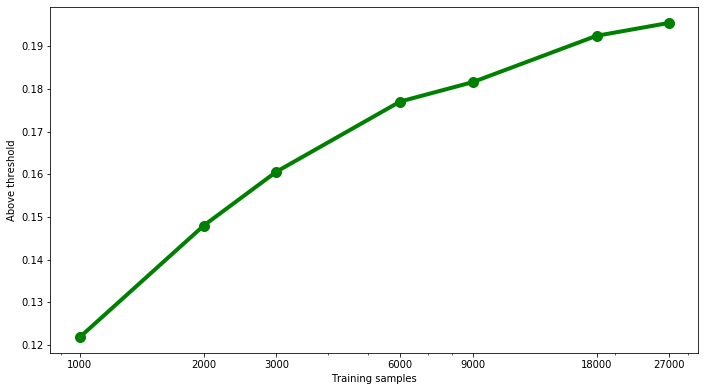

In [38]:
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
plt.subplot(1,2,1)
plt.plot([min(trn_size,s) for s in trn_sizes], median_cc, marker='o', ms=10, color='g', lw=4)
plt.xscale('log')
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Above threshold')

In [39]:
filename = output_dir + "validation_above_threshold_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

Text(0, 0.5, 'Validation accuracies')

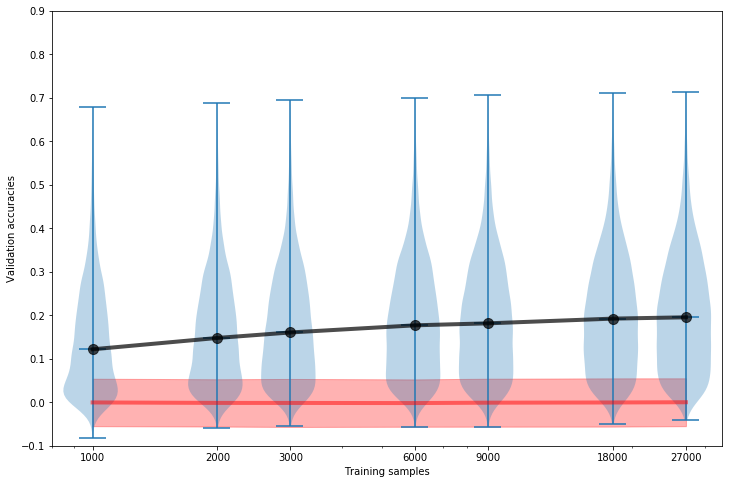

In [40]:
fig=plt.figure(figsize=(12,8))
#plt.hlines(y=[0], xmin=800, xmax=33000, color='r', lw=4, alpha=.5)
plt.plot([min(trn_size,s) for s in trn_sizes], cc_mns, color='r', lw=4, alpha=.5)
plt.fill_between([min(trn_size,s) for s in trn_sizes], np.array(cc_mns)-np.array(cc_ths), np.array(cc_mns)+np.array(cc_ths), color='r', alpha=0.3)
plt.violinplot(result_cc, positions=[min(trn_size,s) for s in trn_sizes], widths=np.array([min(trn_size,s) for s in trn_sizes])*.3, showmedians=True)
plt.plot([min(trn_size,s) for s in trn_sizes], median_cc, marker='o', ms=10, color='k', lw=4, alpha=.7)
plt.xscale('log')
plt.xlim([800, 33000])
plt.ylim([-.1, .9])
plt.gca().set_yticks(np.linspace(-.1,.9, 11))
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Validation accuracies')

In [80]:
filename = output_dir + "validation_scaling_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# Reload stuff

In [41]:
fwrf_scaling_set = h5py.File(output_dir + "dnn_fwrf_Apr-06-2020_2050_scaling.h5py", 'r')
fwrf_scaling = embed_dict({k: np.copy(d) for k,d in fwrf_scaling_set.items()})
print (fwrf_scaling.keys())
fwrf_scaling_set.close()

dict_keys(['cc_mn', 'cc_th', 'ho_sizes', 'lambdas', 'max_trn_size', 'result0', 'result1', 'result2', 'result3', 'result4', 'result5', 'result6', 'trn_sizes', 'val_size', 'voxel_index', 'voxel_roi'])


In [42]:
fwrf_result_cc, fwrf_cc_ths, fwrf_cc_mns, fwrf_median_cc, fwrf_top_cc, fwrf_count_cc = [],[],[],[],[],[]
for i,ts in enumerate(fwrf_scaling['trn_sizes']):
    fwrf_cc_mns += [fwrf_scaling['result%d'%i]['cc_mn'],]
    fwrf_cc_ths += [fwrf_scaling['result%d'%i]['cc_th'],]
    fwrf_result_cc += [fwrf_scaling['result%d'%i]['val_cc'],]
    fwrf_median_cc += [np.median(fwrf_scaling['result%d'%i]['val_cc'])]
    fwrf_top_cc += [np.max(fwrf_scaling['result%d'%i]['val_cc'])]
fwrf_cc_mn = np.mean(fwrf_cc_mns)    
fwrf_cc_th = np.mean(fwrf_cc_ths)
for i,ts in enumerate(fwrf_scaling['trn_sizes']):
    fwrf_count_cc += [np.sum(fwrf_scaling['result%d'%i]['val_cc']>(fwrf_cc_mn+fwrf_cc_th))]

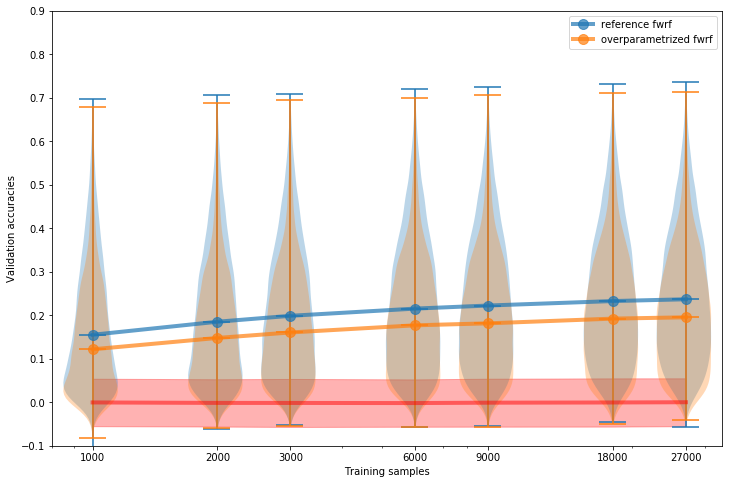

In [43]:
fig=plt.figure(figsize=(12,8))
#plt.hlines(y=[0], xmin=800, xmax=33000, color='r', lw=4, alpha=.5)
plt.plot([min(trn_size,s) for s in trn_sizes], cc_mns, color='r', lw=4, alpha=.5)
plt.fill_between([min(trn_size,s) for s in trn_sizes], np.array(cc_mns)-np.array(cc_ths), np.array(cc_mns)+np.array(cc_ths), color='r', alpha=0.3)
###
p1=plt.violinplot(fwrf_result_cc, positions=[min(trn_size,s) for s in trn_sizes], widths=np.array([min(trn_size,s) for s in trn_sizes])*.3, showmedians=True)
p2=plt.violinplot(result_cc, positions=[min(trn_size,s) for s in trn_sizes], widths=np.array([min(trn_size,s) for s in trn_sizes])*.3, showmedians=True)
###
plt.plot([min(trn_size,s) for s in trn_sizes], fwrf_median_cc, marker='o', ms=10, color=p1['bodies'][0].get_fc()[0], lw=4, alpha=.7, label='reference fwrf')
plt.plot([min(trn_size,s) for s in trn_sizes], median_cc, marker='o', ms=10, color=p2['bodies'][0].get_fc()[0], lw=4, alpha=.7, label='overparametrized fwrf')
###
plt.xscale('log')
plt.xlim([800, 33000])
plt.ylim([-.1, .9])
plt.gca().set_yticks(np.linspace(-.1,.9, 11))
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Validation accuracies')
plt.legend()

In [46]:
filename = output_dir + "validation_scaling_comparision_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 